# Non linear feature extraction of the stratosphere

- https://github.com/geopandas/geopandas/issues/1166

## Data exploration:

In [15]:
#imports:

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import geopandas
import geoplot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

### Load data: 

In [47]:
anomalies_cf = pd.read_csv('../data/anomalies_coefficients.csv', sep=',')
raw_cf = pd.read_csv('../data/raw_data_coefficients.csv', sep=',')
basis_cf = pd.read_csv('../data/basis_functions.csv', sep=',')

In [48]:
basis_cf.head(3)

,Unnamed: 0,Lon,Lat,X1,X2,X3,X4,X5,X6,X7,...,X992,X993,X994,X995,X996,X997,X998,X999,X1000,X1001
0,1,0.00,89.25,1,0.010141,0.040319,-2.368483,0.001031,0.000077,-0.102981,...,3.631613e-13,3.464664e-14,-3.341165e-13,2.849425e-13,1.557925e-13,5.982969e-13,6.331329e-13,2.241741e-13,-2.846185e-13,-5.775125e-13
1,2,0.75,89.25,1,0.009612,0.040449,-2.368483,0.001029,0.000104,-0.101771,...,4.067050e-13,-4.938318e-16,-3.507720e-13,2.985671e-13,1.810982e-13,5.570756e-13,6.526212e-13,1.829743e-13,-3.911114e-13,-5.002182e-13
2,3,1.50,89.25,1,0.009082,0.040571,-2.368483,0.001026,0.000131,-0.100545,...,3.982352e-13,-3.830620e-14,-4.210252e-13,2.607462e-13,1.647441e-13,5.954190e-13,6.264252e-13,2.505362e-13,-4.883408e-13,-3.861563e-13


In [4]:
raw_cf.head(3)

,Unnamed: 0,Date,X1,X2,X3,X4,X5,X6,X7,X8,...,X992,X993,X994,X995,X996,X997,X998,X999,X1000,X1001
0,1,1979-01-01 00:00:00,0.000443,0.000059,0.000018,-0.000257,0.000027,0.000018,-0.000047,-0.000025,...,1.326600e-06,-2.590231e-07,1.111734e-06,-7.988864e-07,4.408012e-08,-1.217306e-08,9.282409e-07,-5.001676e-07,-4.883183e-08,1.128947e-06
1,2,1979-01-01 06:00:00,0.000436,0.000057,0.000017,-0.000250,0.000028,0.000011,-0.000043,-0.000030,...,3.176703e-07,-2.685431e-07,5.769547e-08,6.127967e-07,4.295968e-08,-7.938383e-08,1.063049e-06,-5.364016e-07,7.481122e-07,2.706997e-07
2,3,1979-01-01 12:00:00,0.000434,0.000058,0.000010,-0.000249,0.000034,0.000009,-0.000043,-0.000029,...,1.135065e-06,-1.217742e-06,1.196999e-07,-2.562468e-07,-6.708924e-08,7.292826e-08,1.581833e-07,-4.967490e-07,-8.876771e-08,-9.832148e-07


In [5]:
anomalies_cf.head(3)

,Unnamed: 0,Date,X1,X2,X3,X4,X5,X6,X7,X8,...,X992,X993,X994,X995,X996,X997,X998,X999,X1000,X1001
0,1,1979-01-01 00:00:00,0.087772,0.306971,-0.358278,-0.713848,0.431876,0.233288,0.079006,0.182841,...,0.010085,0.000343,0.013018,-0.008956,0.001028,-0.000141,0.009586,-0.004209,0.000906,0.011727
1,2,1979-01-01 06:00:00,0.045790,0.298297,-0.373760,-0.684706,0.456666,0.171122,0.098944,0.153985,...,0.004224,-0.002052,0.002568,0.003769,0.000829,-0.001214,0.010168,-0.005202,0.007966,0.002296
2,3,1979-01-01 12:00:00,0.044001,0.297177,-0.449389,-0.679847,0.513206,0.161827,0.082390,0.152011,...,0.009204,-0.010951,0.000831,-0.004194,-0.000835,0.001100,-0.000148,-0.005812,0.000562,-0.005325


In [112]:
# Sample `February 6th 1981 at 6AM':
date = '1981-02-06 06:00:00'
df = anomalies_cf
sample_df = df[df.Date == date]

In [49]:
# Look at small sample of data:
#sample_anomaly = anomalies_cf.sample(1)
sample_array = np.array(sample_df.drop(['Unnamed: 0', 'Date'], axis=1))
basis_array = np.array(basis_cf.drop(['Unnamed: 0', 'Lon', 'Lat'], axis=1))

print(
    f'Coordinates shape:{sample_array.shape} and Basis array shape:{basis_array.shape}'
)

Coordinates shape:(1, 1001) and Basis array shape:(38400, 1001)


In [51]:
def basis_transf(coordinates, basis):
    """
    @input: 
    - basis np.array of shape (1001, 38400)
    - coordinates np.array of shape (1001, 1)
    """
    x = np.zeros(38400)
    if coordinates.shape == (1, 1001):
        coordinates = coordinates.T
    if basis.shape == (38400, 1001):
        basis = basis.T
    for i in range(len(coordinates)):
        x += coordinates[i] * basis[i]
    return x

In [113]:
# Apply basis transformation to sample point:
X_sample = pd.DataFrame(
    data={
        'longitude': basis_cf['Lon'],
        'latitude': basis_cf['Lat'],
        'PV_values': basis_transf(sample_array, basis_array)
    })

In [128]:
def plot_sample(X_sample, option = 'color'):
    Z = X_sample.pivot(index='latitude',
                       columns='longitude',
                       values='PV_values')

    fig = plt.figure(figsize=(8, 8))

    m = Basemap(projection='npstere', boundinglat=28, lon_0=0, resolution='l')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80., 81., 20.),
                    labels=[False, False, False, False])
    m.drawmeridians(np.arange(-180., 181., 20.),
                    labels=[True, False, True, True])
    
    latitude = Z.index.values
    longitude = Z.columns.values
    
    lons, lats = np.meshgrid(longitude, latitude)
    if option == 'color':
        m.pcolor(lons, lats, Z.values, latlon=True, cmap='RdYlBu')
    if option == 'contour':
        m.contourf(lons, lats, Z.values, latlon=True, cmap='RdYlBu')
    m.colorbar()

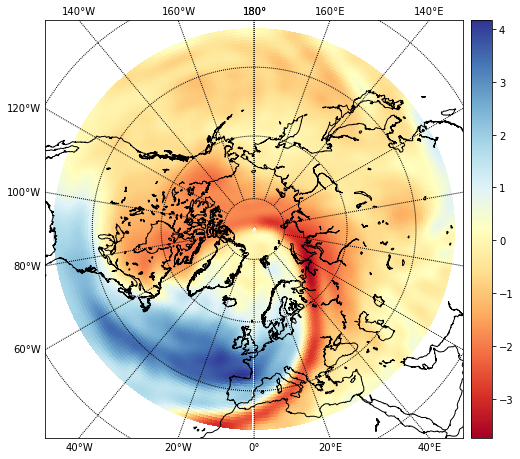

In [129]:
plot_sample(X_sample, 'color')

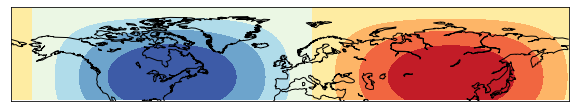

In [111]:
df_test = pd.DataFrame(
    data={
        'longitude': basis_cf['Lon'],
        'latitude': basis_cf['Lat'],
        'PV_values': basis_cf['X2']
    })

Z_ = X_sample.pivot(index='latitude', columns='longitude', values='PV_values')

fig = plt.figure(figsize=(10, 15))

#m = Basemap(projection='npstere', boundinglat=28, lon_0=0, resolution='l')
m = Basemap(llcrnrlon=-180.,llcrnrlat=29.,urcrnrlon=180,urcrnrlat=90., projection='cyl')
m.drawcoastlines()

latitude = Z_.index.values
longitude = Z_.columns.values

lons, lats = np.meshgrid(longitude, latitude)
m.contourf(lons, lats, Z.values, latlon=True, cmap='RdYlBu')

## PCA: 

In [42]:
pca = PCA(n_components=10)
X = np.array(df.drop(['Unnamed: 0', 'Date'], axis=1))
pca.fit(X)

singular_values = pca.singular_values_
explained_variance_ratio_ = pca.explained_variance_ratio_
components = pca.components_

print("Singular values: {sv} \nExplained variance: {ev}".
      format(sv=singular_values, ev=explained_variance_ratio_))

Singular values: [62.90210292 59.13631955 51.79003232 44.98454377 41.44152341 37.20134164
 34.18537409 32.05723778 30.23392738 27.99857049] 
Explained variance: [0.11793901 0.10424032 0.07995019 0.06031895 0.05119158 0.04125194
 0.03483436 0.03063228 0.02724685 0.02336678]


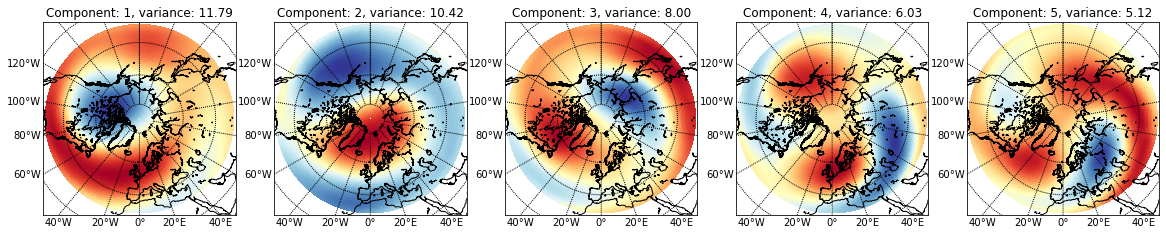

In [44]:
NUM_COMP = 5
fig, axs = plt.subplots(1, NUM_COMP, figsize=(20, 20))

for i in range(NUM_COMP):
    X_sample = pd.DataFrame(
        data={
            'longitude': basis_cv['Lon'],
            'latitude': basis_cv['Lat'],
            'PV_values': basis_transf(components[i], basis_array)
        })

    Z = X_sample.pivot(index='latitude',
                       columns='longitude',
                       values='PV_values')
    
    lons, lats = np.meshgrid(Z.columns.values, Z.index.values)
    
    m = Basemap(projection='npstere',
                boundinglat=29,
                lon_0=0,
                resolution='l',
                ax=axs[i])
    m.drawcoastlines(ax=axs[i])
    m.drawparallels(np.arange(-80., 81., 20.),
                    labels=[False, False, False, False],
                    ax=axs[i])
    m.drawmeridians(np.arange(-180., 181., 20.),
                    labels=[True, False, False, True],
                    ax=axs[i])
    
    m.pcolor(lons, lats, Z.values, latlon=True, cmap='RdYlBu', ax=axs[i])
    
    axs[i].set_title('Component: {}, variance: {:.2f}'.format(
        i + 1, explained_variance_ratio_[i] * 100))

plt.savefig('../data/figures/PCA.png')

## Laplacian decomposition:

In [ ]:
RdYlBu